In [1]:
import os
from collections import defaultdict
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools.utils.settings import DefaultPath as defpath
from tools.utils.utils import get_mongodb_collections

In [15]:
# To read a multindex multicolumns dataframe (as those created for the analyses) use the pd.read_csv() attributes "header" and "index_col"
# pd.read_csv('/path/to/complex/table/strange_pivot.csv', header=[0,1,2], index_col=[0,1])

In [2]:
test_name = 'small_test'

In [4]:
small = True
mongoclient, collections = get_mongodb_collections('wikipedia', small)

In [5]:
test_dir = defpath.data_path.tests + '/' + test_name
results_dir = test_dir + '/results/extracted'

In [6]:
solvers = [('josie', 'set'), ('josie', 'bag'), ('lshforest', 'set'), ('lshforest', 'bag'), ('embedding', 'fasttext')]
q = '1K'

results = pd.read_csv(f'{results_dir}/final_results_q{q}.csv')

In [7]:
results

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size
0,12875,15191.0,josie,set,3.0,3.0,24.0,211.0,3.0
1,12875,11934.0,josie,set,2.0,2.0,24.0,51.0,2.0
2,12875,11281.0,josie,set,2.0,2.0,24.0,43.0,2.0
3,12875,17819.0,josie,set,2.0,2.0,24.0,59.0,2.0
4,12875,19772.0,josie,set,2.0,2.0,24.0,48.0,2.0
...,...,...,...,...,...,...,...,...,...
59246,14333,16617.0,lshforest,set,4.0,4.0,40.0,9.0,4.0
59247,14333,17170.0,lshforest,set,8.0,8.0,40.0,22.0,8.0
59248,14333,13878.0,lshforest,set,12.0,12.0,40.0,44.0,12.0
59249,14333,11318.0,lshforest,set,11.0,11.0,40.0,64.0,11.0


In [8]:
results = results.dropna()

In [9]:
results.shape

(59133, 9)

In [11]:
results['difference_overlap'] = results['algorithm_overlap'] - results['sloth_overlap']
results['algorithm_overlap_norm'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)

/tmp/ipykernel_42328/1255061597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['difference_overlap'] = results['algorithm_overlap'] - results['sloth_overlap']
/tmp/ipykernel_42328/1255061597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['algorithm_overlap_norm'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)


## I vari metodi per caso ritornano risultati che in realtà non hanno overlap reale?

JOSIE no perché esatto, LSHForest può sbagliare (raramente)

In [12]:
x = []
for am, am_group in results.groupby(by=["algorithm", "mode"]):
    for query_id, q_group in am_group.groupby(by=["query_id"]):
        cnt = ((q_group['sloth_overlap'] == 0)).sum()
        num_query_results = q_group.count().values.tolist()[0]
        x.append([am[0], am[1], query_id[0], num_query_results, cnt, cnt / num_query_results])

x = pd.DataFrame(x, columns=['algorithm', 'mode', 'query_id', 'query_size', 'zero_overlap_cnt', 'zero_overlap_ratio'])

In [13]:
null_ratio_pivot = pd.pivot_table(x, values=['zero_overlap_ratio'], index=['algorithm', 'mode'], aggfunc=['mean', 'std', 'min', 'max'])
null_ratio_pivot

mean                std                min  \
                   zero_overlap_ratio zero_overlap_ratio zero_overlap_ratio   
algorithm mode                                                                
embedding fasttext           0.552857           0.347671                0.0   
          tabert             0.598956           0.365482                0.0   
josie     set                0.000000           0.000000                0.0   
lshforest set                0.001131           0.033634                0.0   

                                  max  
                   zero_overlap_ratio  
algorithm mode                         
embedding fasttext                1.0  
          tabert                  1.0  
josie     set                     0.0  
lshforest set                     1.0

In alcuni casi JOSIE sembra sbagliare nonostante sia esatto, probabilmente sono quelli in cui però va in time out e non riesce a ricostruire l'overlap effettivo nel tempo massimo.

In [14]:
x = results[(results['algorithm'] == 'josie') & (results['mode'] == 'set')]

In [15]:
results[(results['sloth_overlap'] == 0) & (results['algorithm_overlap'] != 0) & (results['algorithm'] != 'lshforest')]

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,difference_overlap,algorithm_overlap_norm
33824,14341,11346.0,embedding,fasttext,19.0,0.0,92.0,49.0,19.0,19.0,19.0
33825,14341,11411.0,embedding,fasttext,41.0,0.0,92.0,150.0,41.0,41.0,41.0
34383,10367,5957.0,embedding,fasttext,1.0,0.0,15.0,52.0,1.0,1.0,1.0
34708,16578,10268.0,embedding,fasttext,9.0,0.0,74.0,70.0,9.0,9.0,9.0
34712,16578,13591.0,embedding,fasttext,10.0,0.0,74.0,72.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
45957,15065,14940.0,embedding,tabert,22.0,0.0,64.0,172.0,22.0,22.0,22.0
49316,13746,412.0,embedding,tabert,1.0,0.0,460.0,78.0,1.0,1.0,1.0
49553,11743,14295.0,embedding,tabert,1.0,0.0,12.0,16.0,1.0,1.0,1.0
49865,13896,15556.0,embedding,tabert,6.0,0.0,69.0,65.0,6.0,6.0,6.0


In [29]:
from tools.utils.utils import get_one_document_from_mongodb_by_key
from tools.utils.utils import _create_token_set

mongoclient, collections = get_mongodb_collections(False)

qdoc = get_one_document_from_mongodb_by_key('_id_numeric', 2632194, *collections)
rdoc = get_one_document_from_mongodb_by_key('_id_numeric', 1663620, *collections)

qset = _create_token_set(qdoc['content'], 'set', qdoc['numeric_columns'])
rset = _create_token_set(rdoc['content'], 'set', rdoc['numeric_columns'])

set(qset).intersection(rset)

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '4',
 '5',
 '6',
 '7',
 '8',
 '82nd',
 '9',
 'ATL',
 'BRI',
 'Buick',
 'CAR',
 'CLT',
 'Chevy',
 'DAR',
 'DAY',
 'DOV',
 'GLN',
 'IND DNQ',
 'MAR',
 'MCH',
 'MCH DNQ',
 'Make',
 'NASCAR Winston Cup Series results',
 'NHA',
 'NSV',
 'NWS',
 'Olds',
 'PHO',
 'PHO DNQ',
 'POC',
 'Pontiac',
 'RCH',
 'RSD',
 'RSD 25',
 'RSD 29',
 'RSD 40',
 'SON 23',
 'SON 33',
 'TAL',
 'TWS',
 'Team',
 '{{Tooltip NWCC NASCAR Winston Cup classification}}'}

In [22]:
print(','.join(map(str, qdoc['numeric_columns'])))
print(','.join(map(str, rdoc['numeric_columns'])))

1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
from tools.utils.utils import apply_sloth

apply_sloth(qdoc['content'], rdoc['content'], qdoc['numeric_columns'], rdoc['numeric_columns'], verbose=True)

Detected 1365 seed(s) in 0.014682531356811523 seconds.


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f892f99d2a0>>
Traceback (most recent call last):
  File "/data4/nanni/anaconda3/envs/nanni-tesi-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
  File "/data4/nanni/anaconda3/envs/nanni-tesi-env/lib/python3.10/site-packages/timeout_decorator/timeout_decorator.py", line 69, in handler
    _raise_exception(timeout_exception, exception_message)
  File "/data4/nanni/anaconda3/envs/nanni-tesi-env/lib/python3.10/site-packages/timeout_decorator/timeout_decorator.py", line 45, in _raise_exception
    raise exception()
timeout_decorator.timeout_decorator.TimeoutError: 'Timed Out'


In [16]:
# pd.DataFrame(qdoc['content'])

In [17]:
# pd.DataFrame(rdoc['content'])

## Algorithm vs True Overlap

In [30]:
data = [(am[0], am[1], group) for am, group in results.groupby(by=['algorithm', 'mode'])]

In [31]:
results[(results['algorithm'] == 'josie') & (results['mode'] == 'set')].describe()

,query_id,result_id,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,difference_overlap,algorithm_overlap_norm
count,8627.000000,8627.000000,8627.000000,8627.000000,8627.000000,8627.000000,8627.000000,8627.000000,8627.000000
mean,11959.690970,10306.680770,6.945404,9.094007,58.259302,160.113945,6.945404,-2.148603,0.772932
std,5392.182989,5624.218601,12.973833,24.402531,108.318793,282.105645,12.973833,17.099874,0.500599
min,19.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,-610.000000,0.008621
25%,8088.500000,5560.000000,1.000000,2.000000,16.000000,25.000000,1.000000,0.000000,0.500000
50%,12626.000000,10448.000000,3.000000,4.000000,28.000000,60.000000,3.000000,0.000000,0.721519
75%,16418.000000,15173.000000,8.000000,8.000000,57.000000,178.000000,8.000000,0.000000,0.923077
max,19935.000000,19998.000000,512.000000,1122.000000,1998.000000,3413.000000,512.000000,36.000000,9.000000


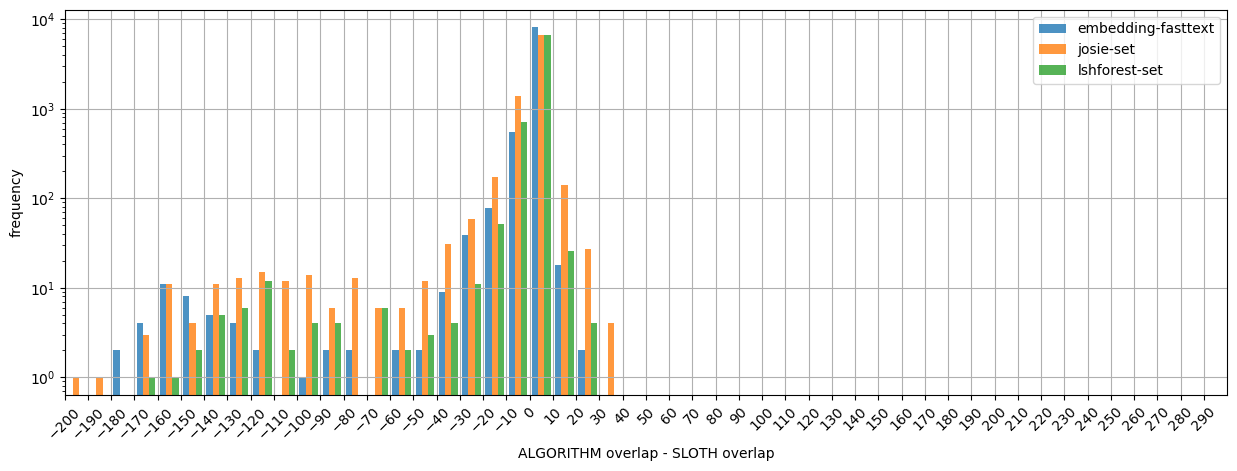

In [32]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = -200, 300, 10

ax.hist([d[2]['difference_overlap'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.grid()
ax.set_xlabel('ALGORITHM overlap - SLOTH overlap')
ax.set_ylabel('frequency')

plt.legend()
plt.show()

In [33]:
data = [(am[0], am[1], group) for am, group in results.groupby(by=['algorithm', 'mode'])]

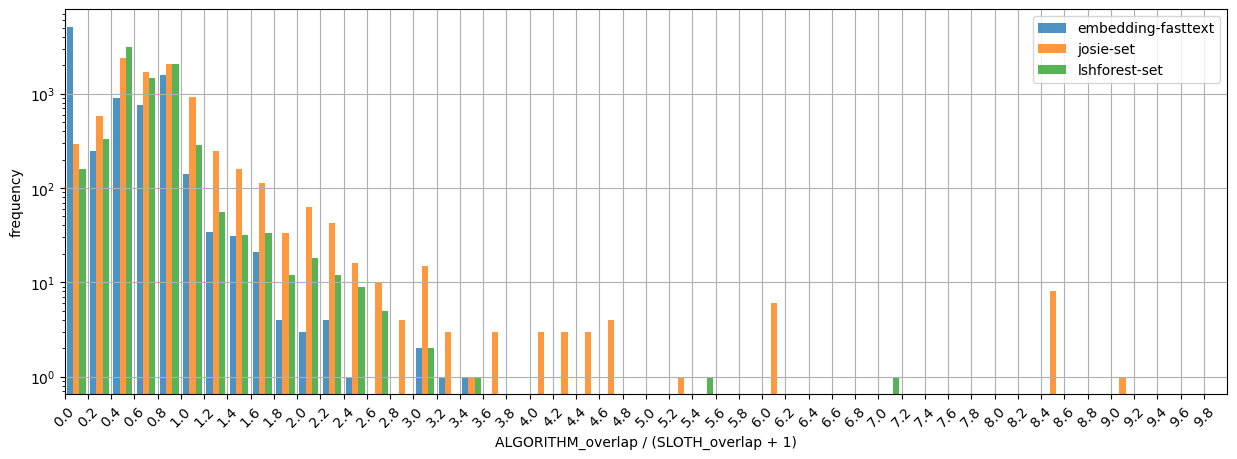

In [34]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = 0, 10, 0.2

ax.hist([d[2]['algorithm_overlap_norm'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.grid()
ax.set_xlabel('ALGORITHM_overlap / (SLOTH_overlap + 1)')
ax.set_ylabel('frequency')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)

plt.legend()
plt.show()

In [35]:
results[(results['algorithm'] == 'josie') & (results['mode'] == 'bag') & (results['algorithm_overlap'] < results['sloth_overlap'])]

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,difference_overlap,algorithm_overlap_norm


## Creating Silver Standard

In [16]:
silver_standard = defaultdict(set)

results_ids = results.convert_dtypes().groupby(by='query_id')[['result_id', 'sloth_overlap']]

for query_id, ids_overlaps in results_ids:
    for i in ids_overlaps.values:
        _id, _overlap = i
        silver_standard[query_id].add((_id, _overlap))

for query_id in silver_standard.keys():
    silver_standard[query_id] = sorted(list(silver_standard[query_id]), key=lambda x: x[1], reverse=True)

## Precision at p - $P@p$
Corresponds to the number of relevant results among the top $p$ retrieved documents. Fails to take into account the positions of the relevant documents among the top $p$.Another shortcoming is that on a query with fewer relevant results than $p$, even a perfect system will have a score less than 1.


In [17]:
import multiprocessing as mp

num_cpu = min(os.cpu_count(), 96)

k_precisions = [1, 3, 5, 10]
work = list(silver_standard.keys())

precision_at_k_results = []


def worker(inp):    
    query_id = inp
    
    qss = [x[1] for x in silver_standard[query_id]]
    prec_results = []

    try:
        avg_overlap = round(statistics.mean(qss), 3)
    except statistics.StatisticsError:
        avg_overlap = 0

    # here errors may be given by single-result queries; 
    # standard deviation cannot be computed for single values (very uncommon cases...)
    try:
        stdev_overlap = round(statistics.stdev(qss))
    except statistics.StatisticsError:
        stdev_overlap = 0
        
    for (algorithm, mode), data in results.groupby(by=["algorithm", "mode"]):
        ids = data[data['query_id'] == query_id]['result_id'].values.tolist()
        for k_precision in k_precisions:
            real_topk = [x[0] for x in silver_standard[query_id][:k_precision]]
            precision_at_k = set(real_topk).intersection(ids)
            
            prec_results.append([query_id, len(qss), avg_overlap, stdev_overlap, algorithm, mode, k_precision, len(precision_at_k)])
    return prec_results


with mp.Pool(processes=num_cpu) as pool:
    print('Start pool work...')
    precision_at_k_results = pool.map(worker, work, chunksize=len(work) // num_cpu)
    print('Pool finished.')
    precision_at_k_results = [x for qres in precision_at_k_results for x in qres]

"""
for query_id in tqdm(silver_standard.keys()):
    qss = [x[1] for x in silver_standard[query_id]]
    
    try:
        avg_overlap = round(statistics.mean(qss), 3)
    except statistics.StatisticsError:
        print('\t', query_id, qss)
        avg_overlap = 0

    # here errors may be given by single-result queries; standard deviation cannot be computed for single values (very uncommon cases...)
    try:
        stdev_overlap = round(statistics.stdev(qss))
    except statistics.StatisticsError:
        print(query_id)
        stdev_overlap = 0
        
    for (algorithm, mode), data in results.groupby(by=["algorithm", "mode"]):
        ids = data[data['query_id'] == query_id]['result_id'].values.tolist()
        for k_precision in k_precisions:
            real_topk = [x[0] for x in silver_standard[query_id][:k_precision]]
            precision_at_k = set(real_topk).intersection(ids)
            
            precision_at_k_results.append([query_id, len(qss), avg_overlap, stdev_overlap, algorithm, mode, k_precision, len(precision_at_k)])
"""

columns = [
    'query_id',
    'silver_std_size',
    'silver_std_ov_mean',
    'silver_std_ov_stdev',
    'algorithm',
    'mode',
    'k',
    'precision_at_k'
]

precision_at_k_results = pd.DataFrame(precision_at_k_results, columns=columns)
# precision_at_k = precision_at_k_results.sort_values(by=['silver_std_size', 'query_id'], ascending=False)

Start pool work...
Pool finished.


In [19]:
precision_at_k_results.head()

,query_id,silver_std_size,silver_std_ov_mean,silver_std_ov_stdev,algorithm,mode,k,precision_at_k
0,19,37,13.27,13,embedding,fasttext,1,1
1,19,37,13.27,13,embedding,fasttext,3,2
2,19,37,13.27,13,embedding,fasttext,5,3
3,19,37,13.27,13,embedding,fasttext,10,6
4,19,37,13.27,13,embedding,tabert,1,0


In [18]:
patk_pivot = pd.pivot_table(precision_at_k_results, values=['precision_at_k'], index=['algorithm', 'mode'], columns=['k'], aggfunc=['mean', 'std', 'max'])
patk_pivot

mean                                 std  \
                   precision_at_k                      precision_at_k   
k                              1      3      5      10             1    
algorithm mode                                                          
embedding fasttext          0.407  1.020  1.553  2.693       0.491521   
          tabert            0.279  0.742  1.129  2.051       0.448732   
josie     set               0.805  2.160  3.452  6.276       0.396399   
lshforest set               0.345  0.895  1.380  2.524       0.475606   

                                                            max            
                                                 precision_at_k            
k                         3         5         10             1  3  5   10  
algorithm mode                                                             
embedding fasttext  1.011248  1.424507  2.181630              1  3  5   9  
          tabert    0.955169  1.368295  2.131418              1  3  5   9  
josie     set       1.016579  1.581201  2.817403              1  3  5  10  
lshforest set       0.970008  1.365087  2.169362              1  3  5   9

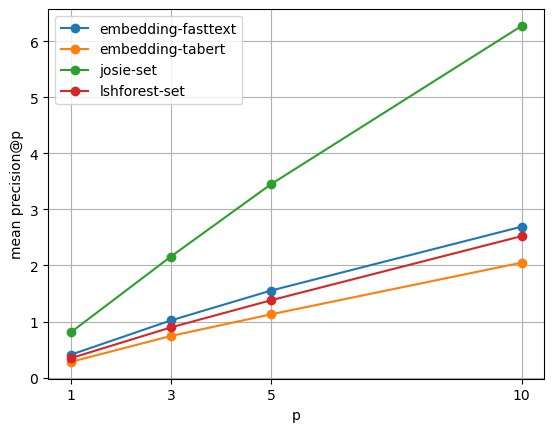

In [20]:
for row, label in zip(patk_pivot['mean', 'precision_at_k'].values, patk_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p')

plt.legend()
plt.grid()

In [21]:
scaled_patk_pivot = patk_pivot['mean']['precision_at_k'] / np.array([1, 3, 5, 10])
scaled_patk_pivot

k                      1         3       5       10
algorithm mode                                     
embedding fasttext  0.407  0.340000  0.3106  0.2693
          tabert    0.279  0.247333  0.2258  0.2051
josie     set       0.805  0.720000  0.6904  0.6276
lshforest set       0.345  0.298333  0.2760  0.2524

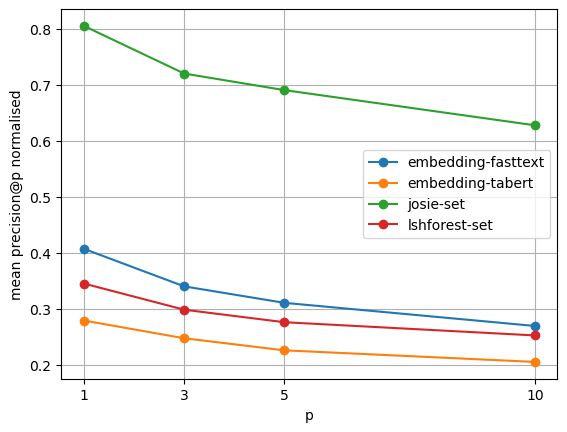

In [41]:
for row, label in zip(scaled_patk_pivot.values, patk_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p normalised')

plt.legend()
plt.grid()

In [27]:
precision_at_k_results['precision_norm'] = precision_at_k_results['precision_at_k'] / precision_at_k_results['k']

In [45]:
import matplotlib.colors as mcolors

In [46]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

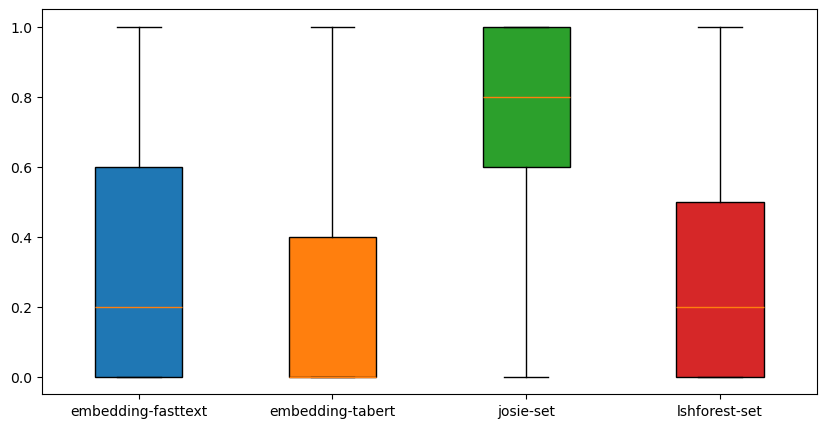

In [47]:
data = [(am[0], am[1], group) for am, group in precision_at_k_results.groupby(by=['algorithm', 'mode'])]
labels = [f'{d[0]}-{d[1]}' for d in data]
colors = [mcolors.TABLEAU_COLORS['tab:blue'], mcolors.TABLEAU_COLORS['tab:orange'], mcolors.TABLEAU_COLORS['tab:green'], mcolors.TABLEAU_COLORS['tab:red']]

plt.figure(figsize=(10, 5))
bplot = plt.boxplot([d[2]['precision_norm'] for d in data],
            patch_artist=True,
            labels=labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

## Normalized Discontinued Cumulative Gain - $nDCG@p$

Search result lists vary in length depending on the query. Comparing a search engine's performance from one query to the next cannot be consistently achieved using DCG alone, so the cumulative gain at each position for a chosen value of $ p $ should be normalized across queries. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $p$, also called Ideal DCG (IDCG) through that position. For a query, the normalized discounted cumulative gain, or nDCG, is computed as: 

$ nDCG_{p} = {DCG_{p} \over IDCG_{p}} $

where $ IDCG_{p} $ is the ideal discounted cumulative gain,

$ IDCG_{p} = \sum_{i=1}^{|REL_{p}|} {2^{rel_{i}} - 1 \over log_{2}(i + 1)}$

where $ REL_{p} $ represents the list of relevant documents (ordered by their relevance) in the corpus up to position $p$

In [59]:
from math import log2

def ndcg_at_p(true_relevances, scores, p):
    p = min(p, len(true_relevances), len(scores))
    if p <= 0: # because computing nDCG is meaningful only if there is more than one document 
        return 0, 1
    idcg = sum(rel / log2(i + 1) for i, rel in enumerate(true_relevances[:p], start=1))
    dcg = sum(rel / log2(i + 1) for i, rel in enumerate(scores[:p], start=1))
    if idcg < dcg:
        raise ZeroDivisionError()

    return dcg / idcg, p

In [62]:

def worker_ndcg(query_id):
    p = [1, 3, 5, 10]
    ndcg_res = []
    true_relevances = [x[1] for x in silver_standard[query_id]]
    max_silver_standard = true_relevances[0]
    for (algorithm, mode), data in results.groupby(by=['algorithm', 'mode']):
        r = data[data['query_id'] == query_id][['result_id', 'sloth_overlap']]
        result_relevances = [min(max_silver_standard, x[1]) for x in r.values.tolist()]
        for _p in p:
            try: ndcg, _actual_p = ndcg_at_p(true_relevances, result_relevances, _p)
            except ZeroDivisionError: continue
            ndcg_res.append([query_id, len(true_relevances), algorithm, mode, _p, _p - _actual_p, ndcg])
    return ndcg_res

work = list(silver_standard.keys())

# same work list of precision@p
with mp.Pool(num_cpu) as pool:
    ndcg_results = pool.map(worker_ndcg, work, chunksize=len(work) // num_cpu)
    ndcg_results = [x for qres in ndcg_results for x in qres]


In [45]:
# res = get_nDCG_p(silver_standard, results, 1, 3, 5, 10)

In [63]:
df = pd.DataFrame(ndcg_results, columns=['query_id', 'silver_standard_size', 'algorithm', 'mode', 'p', 'missing_p', 'ndcg_p'])

In [66]:
silver_standard_size_threshold = 0
df_thr = df[df['silver_standard_size'] >= silver_standard_size_threshold]

In [67]:
ndcg_pivot = df_thr.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p', 'missing_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                          \
                   missing_p                                  ndcg_p   
p                         1         3         5         10        1    
algorithm mode                                                         
embedding fasttext         0  0.001056    0.0074  0.055085  0.322258   
          tabert           0       0.0       0.0  0.998944  0.282807   
josie     set              0  0.126556  0.267442  0.691372  0.755423   
lshforest set              0  0.273381  0.610363  1.643606  0.394937   

                                                       max                     \
                                                 missing_p          ndcg_p      
p                         3         5         10        1  3  5  10     1  3    
algorithm mode                                                                  
embedding fasttext  0.321642  0.321793  0.342403         0  1  3  8      1  1   
          tabert    0.269129  0.267938   0.26877         0  0  0  2      1  1   
josie     set       0.746951  0.749529  0.756791         0  2  4  9      1  1   
lshforest set       0.412396  0.429793  0.466632         0  2  4  9      1  1   

                          
                          
p                  5  10  
algorithm mode            
embedding fasttext  1  1  
          tabert    1  1  
josie     set       1  1  
lshforest set       1  1

In [68]:
ndcg_pivot = df_thr.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                  max         
                      ndcg_p                               ndcg_p         
p                         1         3         5         10     1  3  5  10
algorithm mode                                                            
embedding fasttext  0.322258  0.321642  0.321793  0.342403      1  1  1  1
          tabert    0.282807  0.269129  0.267938   0.26877      1  1  1  1
josie     set       0.755423  0.746951  0.749529  0.756791      1  1  1  1
lshforest set       0.394937  0.412396  0.429793  0.466632      1  1  1  1

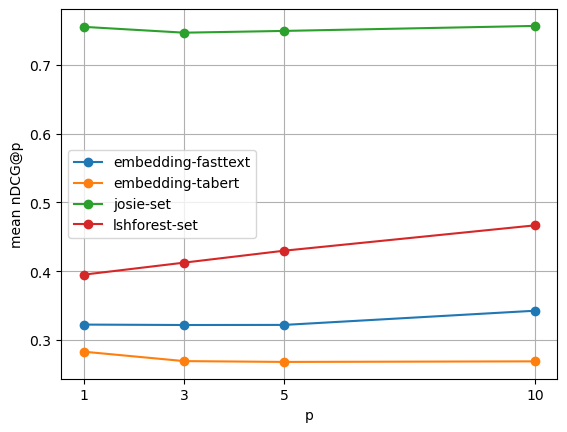

In [69]:
for row, label in zip(ndcg_pivot['mean', 'ndcg_p'].values, ndcg_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel("p")
plt.ylabel("mean nDCG@p")

plt.legend()
plt.grid()

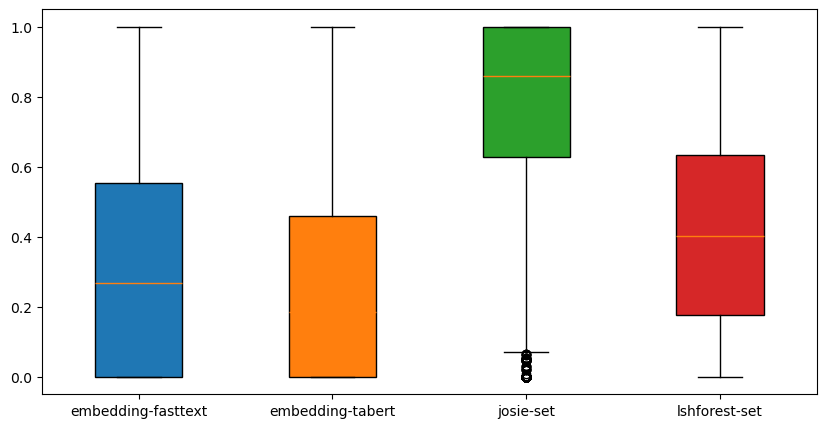

In [70]:
data = [(am[0], am[1], group) for am, group in df.groupby(by=['algorithm', 'mode'])]
labels = [f'{d[0]}-{d[1]}' for d in data]
colors = [mcolors.TABLEAU_COLORS['tab:blue'], mcolors.TABLEAU_COLORS['tab:orange'], mcolors.TABLEAU_COLORS['tab:green'], mcolors.TABLEAU_COLORS['tab:red']]

plt.figure(figsize=(10, 5))
bplot = plt.boxplot([d[2]['ndcg_p'] for d in data],
            patch_artist=True,
            labels=labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

## Analisi tempo

In [ ]:
import itertools

x = [ 
    (
        algorithm, mode, nsamples, 
        pd.read_csv(test_dir + f'/results/base/a{algorithm}_m{mode}_k10_q{nsamples}.csv')['duration'].sum(),  
        pd.read_csv(test_dir + f'/results/base/a{algorithm}_m{mode}_k10_q{nsamples}.csv')['duration'].mean()
    )
    for algorithm, mode, nsamples in itertools.product(['josie', 'lshforest'], ['set', 'bag'], ["1K"])
]

t = pd.DataFrame(x, columns=['algorithm', 'mode', 'num query', 'top-K time total (s)', 'top-K time mean (s)'])
t

,algorithm,mode,num query,top-K time total (s),top-K time mean (s)
0,josie,set,1K,134.172,0.134172
1,josie,bag,1K,187.344,0.187344
2,lshforest,set,1K,6.902,0.006902
3,lshforest,bag,1K,7.167,0.007167
